In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.auto import trange

# Functions for creating a dog

In [2]:
WALKING_TIME = 15
EATING_TIME = 1
PLAYING_TIME = 4

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [72]:
def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return transform_to_dec(value + diff)

def update_walking(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, walking_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, walking_affection_converge_rate)
    return (update_fat, update_affection)

def update_feeding(dog_table_row):
    update_food = min(dog_table_row.iloc[0]['food'] + eating_food_increase, 1.0)
    update_fat = min(dog_table_row.iloc[0]['fat'] + eating_fat_increase, 1.0)
    return (update_food, update_fat)

def update_playing(dog_table_row):
    update_fat = converge(dog_table_row.iloc[0]['fat'], 0.0, playing_fat_converge_rate)
    update_affection = converge(dog_table_row.iloc[0]['affection'], 1.0, playing_affection_converge_rate)
    return (update_fat, update_affection)

def update_food(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['food'], food_consumption_rate)
    ))

def update_affection(dog_table_row):
    return transform_to_dec(max(
        0.0,
        apply_decreasing_rate(dog_table_row.iloc[0]['affection'], affection_consumption_rate)
    ))

def update_happiness(dog_table_row) -> float:  # between 0 and 1
    return min(
        dog_table_row.iloc[0]['food'],
        1.0 - dog_table_row.iloc[0]['fat'],
        dog_table_row.iloc[0]['affection']
    )

def update_alive(dog_table_row):
    return dog_table_row.iloc[0]['alive'] & (dog_table_row.iloc[0]['happiness'] > 0.0)

def new_state_after_1_minute(dog_table, action_taken='NO ACTION'):
    
    dog_table_row = dog_table.tail(1)
    new_state_dog_id = dog_table_row.iloc[0]['dog_id']
    
    new_state_food = update_food(dog_table_row)
    new_state_fat = dog_table_row.iloc[0]['fat']
    new_state_affection = update_affection(dog_table_row)
    
    new_state_last_action_taken = dog_table_row.iloc[0]['last_action_taken']
    new_state_can_action_be_taken = dog_table_row.iloc[0]['can_action_be_taken']
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action']
    
    new_state_minute = dog_table_row.iloc[0]['minute'] + 1
    new_state_minutes_since_last_action = dog_table_row.iloc[0]['minutes_since_last_action'] + 1
    
    new_state_happiness = update_happiness(dog_table_row)
    new_state_alive = update_alive(dog_table_row)
    
    if ((action_taken != 'NO ACTION') & (dog_table_row.iloc[0]['can_action_be_taken'])):
        new_state_last_action_taken = action_taken
        new_state_can_action_be_taken = False
        new_state_minutes_since_last_action = 0
    
    if ((dog_table_row.iloc[0]['last_action_taken'] == 'WALKING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == WALKING_TIME)):
        new_state_fat, new_state_affection = update_walking(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0        

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'FEEDING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == EATING_TIME)):
        new_state_food, new_state_fat = update_feeding(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0

    if ((dog_table_row.iloc[0]['last_action_taken'] == 'PLAYING') &
        (dog_table_row.iloc[0]['minutes_since_last_action'] == PLAYING_TIME)):
        new_state_fat, new_state_affection = update_playing(dog_table_row)
        new_state_last_action_taken = 'NO ACTION'
        new_state_can_action_be_taken = True
        new_state_minutes_since_last_action = 0
        
    dog_table = dog_table.append({
        'dog_id': new_state_dog_id,
        'minute': new_state_minute,
        'happiness': new_state_happiness,
        'food': new_state_food,
        'fat': new_state_fat,
        'affection': new_state_affection,
        'alive': new_state_alive,
        'can_action_be_taken': new_state_can_action_be_taken, 
        'last_action_taken': new_state_last_action_taken,
        'minutes_since_last_action': new_state_minutes_since_last_action
        }, ignore_index=True)
    
    return dog_table

# Functions for RL

## Adapting parameters

In [4]:
def adapt_epsilon(epsilon_initial, t):
    if t == 0:
        return epsilon_initial
    return epsilon_initial / np.ceil( (len(all_overall_reward)+1) / 10000)

In [ ]:
def adapt_gamma(gamma_initial, t):
    if t == 0:
        return gamma_initial
    return gamma_initial / t

In [ ]:
def adapt_alpha(alpha_initial, t):
    if t == 0:
        return alpha_initial
    return alpha_initial / t

## Convergence

In [83]:
def define_convergence(Q_previous, Q, limit_Q_norm):
    distance_q_matrices = np.linalg.norm(Q_previous - Q)
    print(distance_q_matrices)
    convergence = distance_q_matrices < limit_Q_norm
    return convergence

## Create episode

In [ ]:
def create_episode(Q, max_steps, epsilon):
    
    # Initialisation
    dog_table = init_dog_table()
    
    # First state
    state = dog_table.tail(1)

    while check_end_trajectory(state, max_steps):
        
        action = choose_action(state = state, Q = Q, epsilon = epsilon)
        
        reward = get_reward(state)
        
        save_state_action_reward(state, action, reward)
        
        state = get_next_state(state, action)
        
    return dog_table

In [ ]:
def check_end_trajectory(state, max_steps):
    return ((state.iloc[0]['alive']) & (t < max_steps))

In [ ]:
def get_reward(state):
    return state.iloc[0]['happiness']

In [ ]:
def save_state_action_reward(state, action, reward):
    return (state, action, reward)

# RL strategies

## Monte Carlo Policy Evaluation

In [13]:
observation_space_n = 100*100*100
action_space = ['NO ACTION', 'WALKING', 'FEEDING', 'PLAYING']
action_space_n = len(action_space)

### Initialisation ( N(s,a) ; G(s,a) ; Q(s,a) )

In [14]:
def initialize_N(observation_space_n, action_space_n):
    return np.full(
        shape=(observation_space_n, action_space_n),
        fill_value=0
    )

In [15]:
def initialize_G(observation_space_n, action_space_n):
    return np.full(
        shape=(observation_space_n, action_space_n),
        fill_value=0
    )

In [16]:
def initialize_Q(observation_space_n, action_space_n):
    return np.full(
        shape=(observation_space_n, action_space_n),
        fill_value=0
    )

In [80]:
N = initialize_N(observation_space_n, action_space_n)
G = initialize_G(observation_space_n, action_space_n)
Q = initialize_Q(observation_space_n, action_space_n)

### Loop

In [82]:
gamma = 1
epsilon_initial = 0.5
strategy_type = 'first_visit'
convergence = False
cnt = 0
limit_Q_norm = 1
Q_previous = Q.copy()

while not convergence:
    
    cnt += 1
    print(cnt)
    
    epsilon = adapt_epsilon(epsilon_initial, cnt)
    
    all_state_action_episode = []
    
    # Sample a episode
    dog_table = create_episode(Q, max_steps=10000, epsilon=0.5)
    #print(dog_table)
    
    # Get reward
    dog_table.sort_values('minute', ascending=False, inplace=True)
    g_i_t = dog_table['happiness'].cumsum()
    dog_table.sort_values('minute', ascending=True, inplace=True)
    dog_table['g_i_t'] = g_i_t
    
    # for each (state, action) visited
    for t in range(len(dog_table)-1):
        #t = 0
        
        (state_t, action_t, reward_t, state_t_1) = state_action_reward(dog_table, t, action_space)
        #print(state_t, action_t, reward_t, state_t_1)

        if strategy_type == 'first_visit':
            state_action = str(state_t)+'_'+str(action_t)
            if state_action in all_state_action_episode:
                #print('not first')
                #print(dog_table)
                continue
            #print('not first')
            all_state_action_episode.append(state_action)
            N[state_t, action_t] += 1
            #G[state_t, action_t] += reward_t
            #Q[state_t, action_t] = G[state_t, action_t] / N[state_t, action_t]
            
            Q[state_t, action_t] = Q[state_t, action_t] + (reward_t - Q[state_t, action_t]) / N[state_t, action_t]


        if strategy_type == 'every_visit':
            N[state_t, action_t] += 1
            G[state_t, action_t] += reward_t
            Q[state_t, action_t] = G[state_t, action_t] / N[state_t, action_t]
    
    
    if cnt % 100 == 0:
        convergence = define_convergence(Q_previous, Q, limit_Q_norm)
        Q_previous = Q.copy()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
5394.3176584253915
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
0.0


## General format Q-Learning

In [ ]:
# Starting with Q-learning

# while no convergence, we continue
while not convergence:
    
    # adapting parameters (epsilon, gamma, alpha ...)
    epsilon = adapt_epsilon(epsilon_initial, t)
    alpha = adapt_alpha(alpha_initial, t)
    
    # Get a trajectory/episode
    dog_table = create_episode(Q = Q, max_steps = max_steps, epsilon = epsilon)

    # For each step in the trajectory
    for t in range(len(dog_table)-1):
        
        # Get needed info (depending on algo)
        (state_t, action_t, reward_t, state_t_1) = state_action_reward(dog_table, t, action_space)
        
        # Update Q(state, action) value function
        Q = update(Q, state_t, reward_t, action_t, state_t_1, gamma = 1, alpha = alpha)
    
    # Check if we reach convergence
    (convergence, Q_previous) = define_convergence(Q_previous, Q, limit_Q_norm)

## Initialize dog

In [20]:
def init_dog_table(type_init='real'):

    dog_table = pd.DataFrame(columns=[
        'dog_id', 'minute',
        'happiness', 'food', 'fat', 'affection',
        'alive', 'can_action_be_taken', 'last_action_taken', 'minutes_since_last_action'
    ])

    if type_init == 'real':
        dog_table = dog_table.append({
            'dog_id': 1, 'minute': 0,
            'happiness': 0,
            'food': transform_to_dec(0.5), 
            'fat': transform_to_dec(0), 
            'affection': transform_to_dec(0.5),
            'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
            }, ignore_index=True)

    if type_init == 'random':
        dog_table = dog_table.append({
            'dog_id': 1, 'minute': 0,
            'happiness': 0,
            'food': transform_to_dec(random.random()), 
            'fat': transform_to_dec(random.random()), 
            'affection': transform_to_dec(random.random()),
            'alive': True, 'can_action_be_taken': True, 'last_action_taken': 'NO ACTION', 'minutes_since_last_action': 0
            }, ignore_index=True)
    
    dog_table['happiness'] = update_happiness(dog_table)
    
    return dog_table

## Choose action

In [21]:
def choose_action(state, Q, action_space, epsilon):
    
    if np.random.uniform(0, 1) < epsilon:
        action = random.choices(range(len(action_space)), k = 1)[0]
    
    else:
        state_q = get_state_q(state,0)
        action = np.argmax(Q[state_q, :])
    
    return action

## Run an episode

In [22]:
def create_episode(Q, max_steps, epsilon):
    
    dog_table = init_dog_table()
    state = dog_table.tail(1)

    t = 0
    while ((state.iloc[0]['alive']) & (t < max_steps)):
        t += 1
        action = choose_action(
            state = state,
            Q = Q,
            action_space = action_space,
            epsilon = epsilon
        )
        dog_table = new_state_after_1_minute(dog_table, action_taken = action_space[action])
        state = dog_table.tail(1)

    return dog_table

## Make state for Q

In [23]:
def transform_to_dec(value, dec=100):
    return np.floor(dec*value)/dec

In [24]:
def get_state_q(current_state, t):
    return int('{:02d}{:02d}{:02d}'.format(
        min(99,int(current_state.iloc[t]['food']*100)),
        min(99,int(current_state.iloc[t]['fat']*100)),
        min(99,int(current_state.iloc[t]['affection']*100))
    ))

## Define reward

In [48]:
def define_reward(dog_table, t):
    return dog_table.iloc[t]['g_i_t']

## State action reward

In [49]:
def state_action_reward(dog_table, t, action_space):
    
    state_t = get_state_q(dog_table, t)

    action_t_name = dog_table.iloc[t]['last_action_taken'] if (
        dog_table.iloc[t]['minutes_since_last_action'] == 0
    ) else 'NO ACTION'
    
    action_t = action_space.index(action_t_name)

    reward_t = define_reward(dog_table, t)

    state_t_1 = get_state_q(dog_table, t + 1)
    
    return (state_t, action_t, reward_t, state_t_1)


## Update Q function

In [26]:
# Function to learn the Q-value
def update(Q, state_t, reward_t, action_t, state_t_1, gamma, alpha):
    
    Q[state_t, action_t] = Q[state_t, action_t] + alpha * (reward_t + gamma * max(Q[state_t_1,]) - Q[state_t, action_t])
    
    return Q

## Plots

In [11]:
def intermediate_plots(len_steps_plot, all_overall_reward_t):
    
    # Create some mock data
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('episodes')
    ax1.set_ylabel('nber steps', color=color)
    ax1.plot(range(len(len_steps_plot)), len_steps_plot, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('average reward', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(all_overall_reward_t)), all_overall_reward_t, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [12]:
def display_analyse_Q(Q):
    
    analyse_Q = pd.DataFrame(columns=[
        'state_id', 'food_id', 'fat_id', 'affection_id',
        'no_action', 'walking', 'feeding', 'playing',
    ])

    for i in trange(Q.shape[0]):
        analyse_Q = analyse_Q.append({
            'state_id': int(i),
            'food_id': int(np.floor(i/100)),
            'fat_id': int(np.floor(i/10 % 10)),
            'affection_id': int(np.floor(i % 10)),
            'no_action': Q[i,0],
            'walking': Q[i,1],
            'feeding': Q[i,2],
            'playing': Q[i,3]
            }, ignore_index=True)

    analyse_Q.groupby('food_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('fat_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

    analyse_Q.groupby('affection_id').agg({
        'no_action': 'mean',
        'walking': 'mean',
        'feeding': 'mean',
        'playing': 'mean'
    }).plot()

# This is where things are done

In [13]:
observation_space_n = 100*100*100
action_space = ['NO ACTION', 'WALKING', 'FEEDING', 'PLAYING']
action_space_n = len(action_space)

In [14]:
Q = np.full(
    shape=(observation_space_n, action_space_n),
    fill_value=3.25
)

## Get average reward

In [15]:
max_steps = 1000
avg_reward = []
for i in trange(100):
    dog_table = create_episode(Q = Q, max_steps = max_steps, epsilon = 1)
    for t in range(len(dog_table)-1):
        reward_t = (sum(dog_table.loc[dog_table['minute'] >= t]['happiness'])/(len(dog_table)-t))
        avg_reward.append(reward_t)    

In [16]:
avg_reward_init = np.mean(avg_reward)

## Find Q(state,action) value function

In [17]:
max_steps = 1000
epsilon_initial = 0.5
alpha_initial = 0.1
gamma = 1
convergence = False

In [18]:
Q = np.full(
    shape=(observation_space_n, action_space_n),
    fill_value=avg_reward_init
)

In [19]:
Q_previous = Q.copy()
(all_overall_reward, all_overall_reward_plot) = ([], [])
(all_overall_reward_t, all_overall_reward_t_plot) = ([], [])
(len_steps, len_steps_plot) = ([], [])
nber_steps = 0

Iter.    2000 - Steps   333545 - Eps. 0.500000 - Alp. 0.100000 - Dist. 64.00495 - Total R. 61.669 - Avg R. 0.359


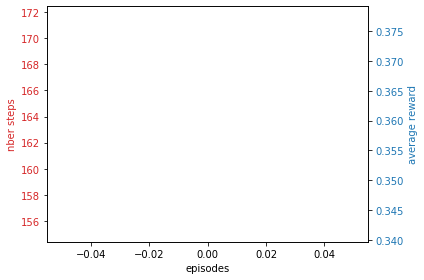

Iter.    3000 - Steps   498491 - Eps. 0.500000 - Alp. 0.100000 - Dist. 29.72263 - Total R. 58.626 - Avg R. 0.363


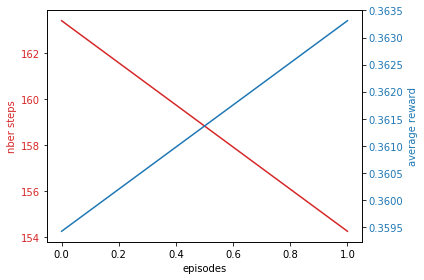

Iter.    4000 - Steps   667871 - Eps. 0.500000 - Alp. 0.100000 - Dist. 27.82291 - Total R. 59.842 - Avg R. 0.362


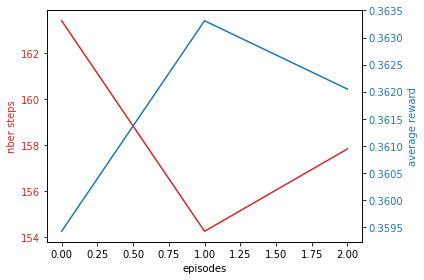

Iter.    5000 - Steps   832124 - Eps. 0.500000 - Alp. 0.100000 - Dist. 25.87215 - Total R. 57.974 - Avg R. 0.365


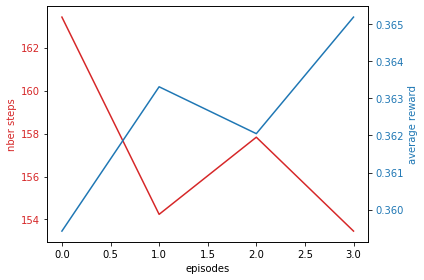

Iter.    6000 - Steps   996976 - Eps. 0.500000 - Alp. 0.100000 - Dist. 25.03107 - Total R. 62.528 - Avg R. 0.357


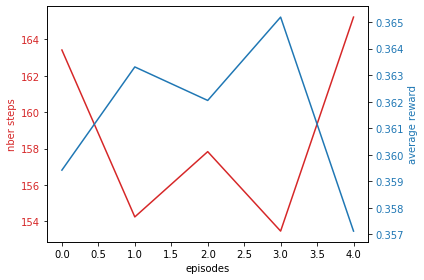

Iter.    7000 - Steps  1163633 - Eps. 0.500000 - Alp. 0.100000 - Dist. 26.10011 - Total R. 72.107 - Avg R. 0.378


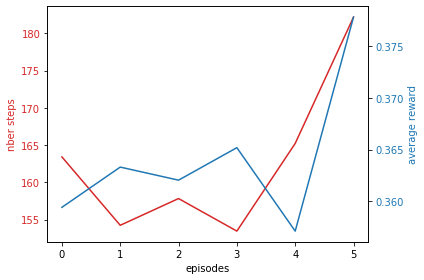

Iter.    8000 - Steps  1331377 - Eps. 0.500000 - Alp. 0.100000 - Dist. 26.41394 - Total R. 62.996 - Avg R. 0.361


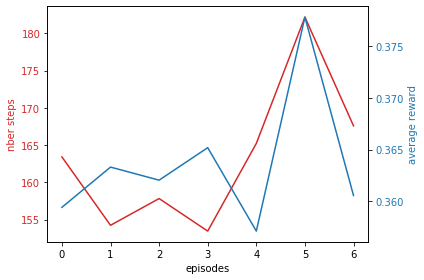

Iter.    9000 - Steps  1494045 - Eps. 0.500000 - Alp. 0.100000 - Dist. 25.32097 - Total R. 60.065 - Avg R. 0.374


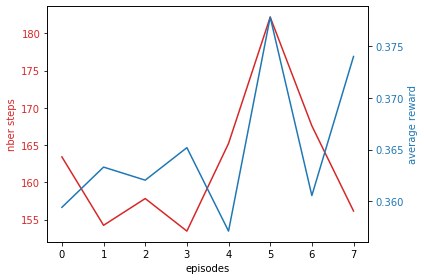

Iter.   10000 - Steps  1668172 - Eps. 0.500000 - Alp. 0.100000 - Dist. 25.97119 - Total R. 63.156 - Avg R. 0.349


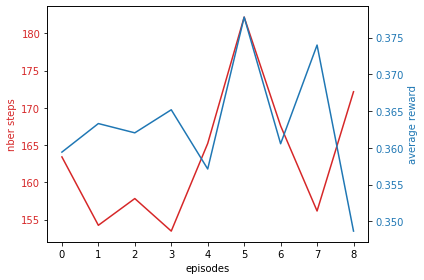

Iter.   11000 - Steps  1841832 - Eps. 0.250000 - Alp. 0.100000 - Dist. 31.57567 - Total R. 69.987 - Avg R. 0.347


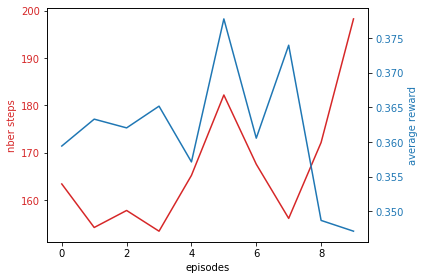

Iter.   12000 - Steps  2016923 - Eps. 0.250000 - Alp. 0.100000 - Dist. 34.81936 - Total R. 57.774 - Avg R. 0.353


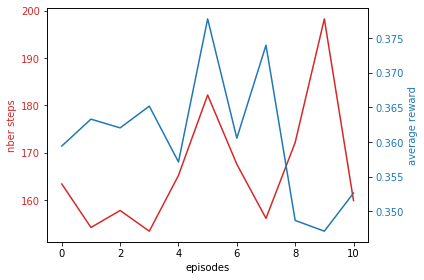

Iter.   13000 - Steps  2192649 - Eps. 0.250000 - Alp. 0.100000 - Dist. 32.17509 - Total R. 61.799 - Avg R. 0.349


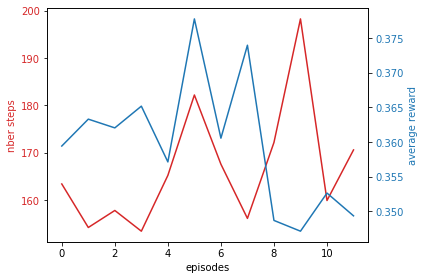

Iter.   14000 - Steps  2370354 - Eps. 0.250000 - Alp. 0.100000 - Dist. 27.97058 - Total R. 63.329 - Avg R. 0.346


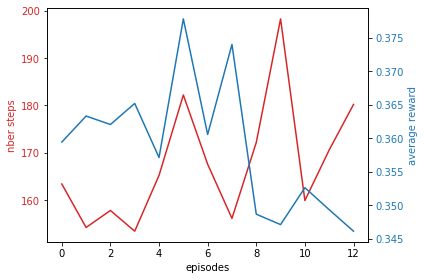

Iter.   15000 - Steps  2543586 - Eps. 0.250000 - Alp. 0.100000 - Dist. 28.47651 - Total R. 62.821 - Avg R. 0.344


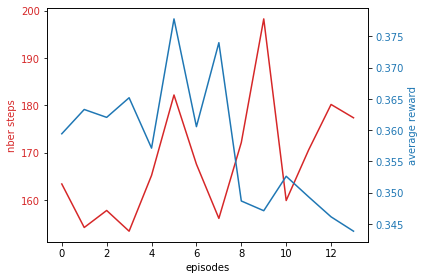

Iter.   16000 - Steps  2715208 - Eps. 0.250000 - Alp. 0.100000 - Dist. 25.66837 - Total R. 59.403 - Avg R. 0.348


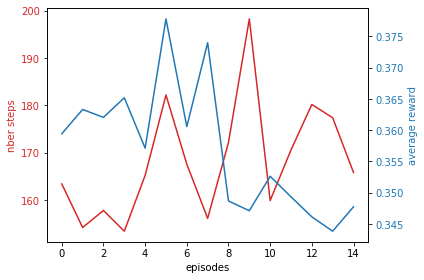

Iter.   17000 - Steps  2884714 - Eps. 0.250000 - Alp. 0.100000 - Dist. 26.10213 - Total R. 65.042 - Avg R. 0.352


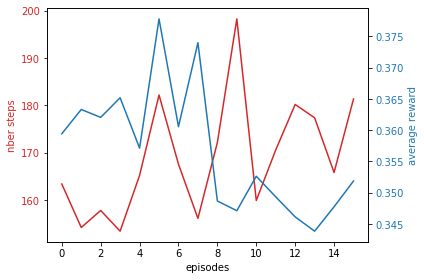

Iter.   18000 - Steps  3057799 - Eps. 0.250000 - Alp. 0.100000 - Dist. 26.28628 - Total R. 61.080 - Avg R. 0.353


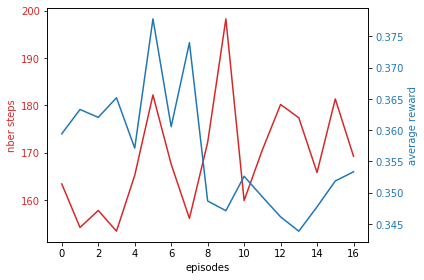

Iter.   19000 - Steps  3226219 - Eps. 0.250000 - Alp. 0.100000 - Dist. 26.50583 - Total R. 56.689 - Avg R. 0.332


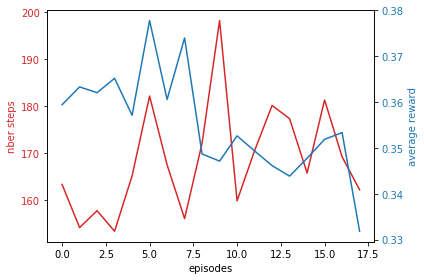

Iter.   20000 - Steps  3389886 - Eps. 0.250000 - Alp. 0.100000 - Dist. 26.23045 - Total R. 58.490 - Avg R. 0.338


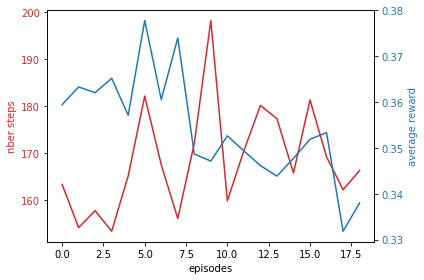

Iter.   21000 - Steps  3556727 - Eps. 0.166667 - Alp. 0.100000 - Dist. 32.46242 - Total R. 53.170 - Avg R. 0.329


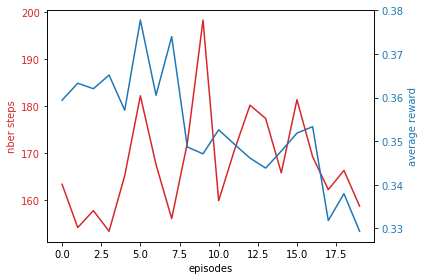

Iter.   22000 - Steps  3721421 - Eps. 0.166667 - Alp. 0.100000 - Dist. 29.48678 - Total R. 57.222 - Avg R. 0.326


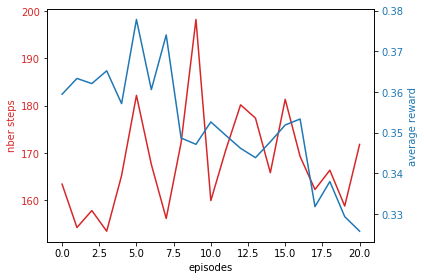

Iter.   23000 - Steps  3885209 - Eps. 0.166667 - Alp. 0.100000 - Dist. 35.32132 - Total R. 56.107 - Avg R. 0.333


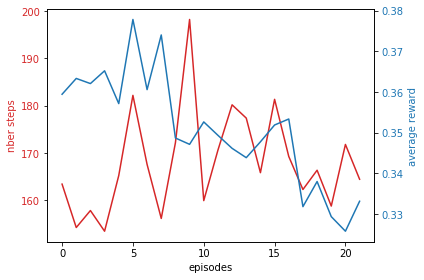

Iter.   24000 - Steps  4052039 - Eps. 0.166667 - Alp. 0.100000 - Dist. 29.50607 - Total R. 55.118 - Avg R. 0.324


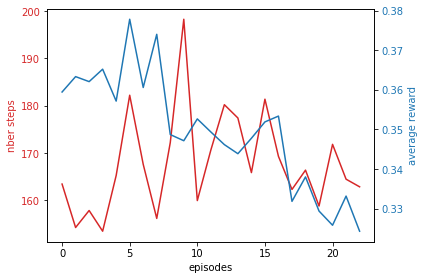

Iter.   25000 - Steps  4224969 - Eps. 0.166667 - Alp. 0.100000 - Dist. 27.55248 - Total R. 62.165 - Avg R. 0.343


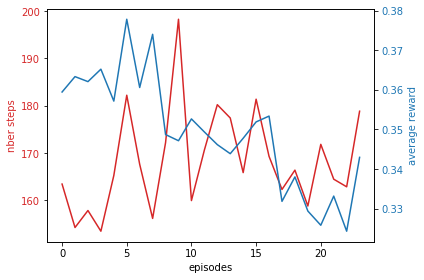

Iter.   26000 - Steps  4390662 - Eps. 0.166667 - Alp. 0.100000 - Dist. 25.04769 - Total R. 56.153 - Avg R. 0.332


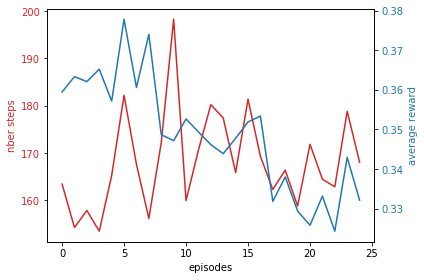

Iter.   27000 - Steps  4555398 - Eps. 0.166667 - Alp. 0.100000 - Dist. 25.83897 - Total R. 52.589 - Avg R. 0.327


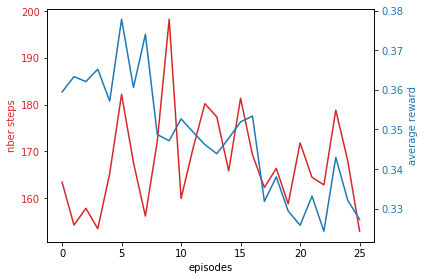

Iter.   28000 - Steps  4723345 - Eps. 0.166667 - Alp. 0.100000 - Dist. 27.58959 - Total R. 54.584 - Avg R. 0.328


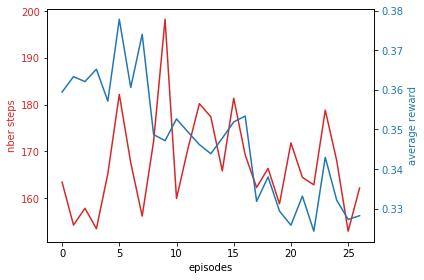

Iter.   29000 - Steps  4886839 - Eps. 0.166667 - Alp. 0.100000 - Dist. 25.77985 - Total R. 55.361 - Avg R. 0.342


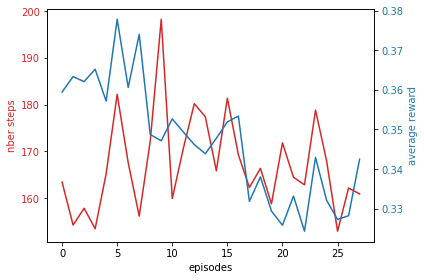

Iter.   30000 - Steps  5046949 - Eps. 0.166667 - Alp. 0.100000 - Dist. 24.98120 - Total R. 49.565 - Avg R. 0.334


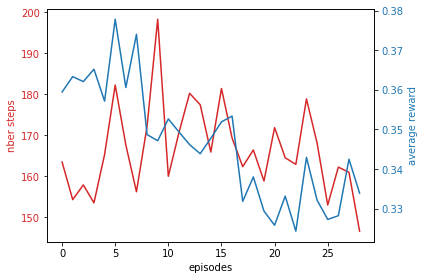

Iter.   31000 - Steps  5192074 - Eps. 0.125000 - Alp. 0.100000 - Dist. 28.01004 - Total R. 45.409 - Avg R. 0.316


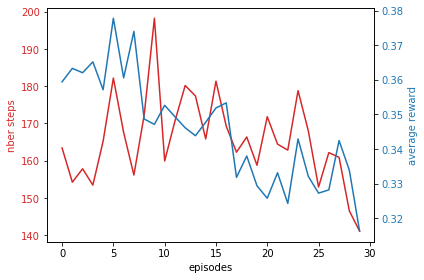

Iter.   32000 - Steps  5345019 - Eps. 0.125000 - Alp. 0.100000 - Dist. 26.49828 - Total R. 52.374 - Avg R. 0.333


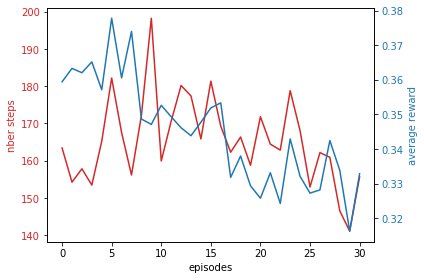

Iter.   33000 - Steps  5492378 - Eps. 0.125000 - Alp. 0.100000 - Dist. 24.78783 - Total R. 44.388 - Avg R. 0.311


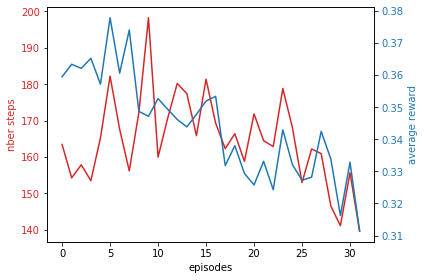

Iter.   34000 - Steps  5644400 - Eps. 0.125000 - Alp. 0.100000 - Dist. 25.60383 - Total R. 40.028 - Avg R. 0.299


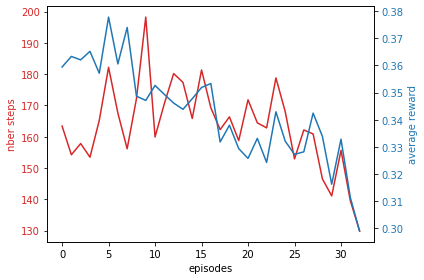

In [ ]:
# Starting with Q-learning

while not convergence:
    
    epsilon = epsilon_initial / np.ceil( (len(all_overall_reward)+1) / 10000)
    alpha = alpha_initial
    
    dog_table = create_episode(Q = Q, max_steps = max_steps, epsilon = epsilon)

    for t in range(len(dog_table)-1):
        (state_t, action_t, reward_t, state_t_1) = state_action_reward(dog_table, t, action_space)

        Q = update(Q, state_t, reward_t, action_t, state_t_1, gamma = 1, alpha = alpha)
    
    overall_reward = sum(dog_table['happiness'])
    
    all_overall_reward.append(overall_reward)
    all_overall_reward_t.append(overall_reward/len(dog_table))
    len_steps.append(len(dog_table)-1)
    nber_steps += len(dog_table)-1
    
    # print(episode, t, overall_reward, overall_reward/t)
    if len(all_overall_reward) % 1000 == 0:
        
        all_overall_reward_plot.append(np.mean(all_overall_reward[-100:]))
        all_overall_reward_t_plot.append(np.mean(all_overall_reward_t[-100:]))
        len_steps_plot.append(np.mean(len_steps[-100:]))
        
        distance_q_matrices = np.linalg.norm(Q_previous - Q)
        convergence = distance_q_matrices < 0.0001
        Q_previous = Q.copy()
        
        print('Iter. {:7d} - Steps {:8d} - Eps. {:0.6f} - Alp. {:0.6f} - Dist. {:06.5f} - Total R. {:06.3f} - Avg R. {:0.3f}'.format(
            len(all_overall_reward),
            nber_steps,
            epsilon, alpha,
            distance_q_matrices,
            np.mean(all_overall_reward[-100:]),
            np.mean(all_overall_reward_t[-100:])
        ))
        intermediate_plots(len_steps_plot, all_overall_reward_t_plot)

    if len(all_overall_reward) % 100000 == 0:
        display_analyse_Q(Q)


## Analysis

In [ ]:
for i in range(Q.shape[1]):
    print(Q[:,1])

In [ ]:
dog_table = create_episode(
        Q = Q,
        max_steps = max_steps,
        epsilon = 0)
dog_table

In [ ]:
sum(dog_table['happiness'])

In [ ]:
Q_previous - Q